# Mapping travel times to hospitals in Ethiopia
## A country-wide analysis to plan COVID-19 response
Forked from the [covid19 repository](https://github.com/datapartnership/covid19) from the Data Partnership authored  by Bruno Sánchez-Andrade Nuño (@brunosan).
Adapted by TFE Energy.

In [41]:
# import modules
from preprocessing import get_population_data, split, n_closest_geodetic
import numpy as np
import rasterio
import logging
import pandas as pd
from rasterio.windows import Window
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import box
import requests #http framework to make mhvpl requests for routes
import json # handle response as json
import pickle
log = logging.getLogger(__name__)

## Pre-process population data

In [42]:
CRS ='epsg:4326'
LOCATION = 'ethiopia'
DATAPATH = 'data/' + LOCATION
RAWFILEPATH  = DATAPATH +  '/raw'
PROCESSEDFILEPATH = DATAPATH + '/processed'
RESULTSFILEPATH = DATAPATH + '/results'

# Facebooks HRSL dataset
map_file = RAWFILEPATH+"/population_eth_2018-10-01.tif"

In [17]:
#Initial scan the raster map with big windows
origins=pd.DataFrame()
window=2000

with rasterio.open(map_file) as src:
    a=src.xy(0,1)
    for left_x in np.arange(0,src.width,window):
        for top_y in np.arange(0,src.height,window):
            out=get_population_data(map_file,left_x,top_y,window,plot=False)
            if out != {}:
                origins=origins.append([out])
        print("%i/%i\r"%(left_x,src.width),end="")

In [18]:
#Perform a splitting pass
#Run this cell as many times as you want to split the windows
print("%i regions need splitting"%len(origins[origins['split']==True]))
olen=len(origins)
for i in np.arange(olen):
    print("%i/%i\r"%(i+1,olen),end="")
    if origins.iloc[i,origins.columns.get_loc('split')] == True:
        origins.iloc[i,origins.columns.get_loc('split')]='done'
        s=split(map_file,origins.iloc[i])
        origins=origins.append(s,sort=False)
print("We now have %i regions, %i will be split in next round"%(len(origins),len(origins[origins['split']==True])))

348 regions need splitting
We now have 1959 regions, 1278 will be split in next round


In [19]:
# Keep the regions with population>1
# and filter out the regions which have been split
origins=origins[origins['tot_pop']>0]
origins=origins[origins['split']!='done']
print("We have %i regions of size %i, %i with population >0"%
      (len(origins),min(origins['window']),len(origins[origins['tot_pop']>0])))

We have 1278 regions of size 1000, 1278 with population >0


In [20]:
#transform into GeoDataFrame
origins = gpd.GeoDataFrame(origins,crs=CRS, geometry=[Point(xy) for xy in zip(origins['center_lon'], origins['center_lat'])])
origins.geometry=origins.apply(lambda r: box(r.left_lon, r.bottom_lat, r.right_lon, r.top_lat, ccw=False),axis=1)
origins = origins.reset_index(drop=True)

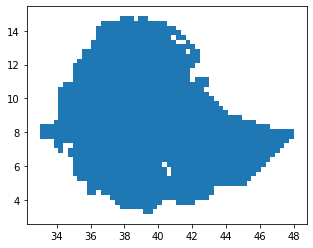

In [21]:
origins.plot()

In [24]:
# save shapefile
origins.to_file(driver = 'GeoJSON', filename= PROCESSEDFILEPATH+'/origins_'+str(len(origins))+'.geojson')
origins.to_file(driver = 'ESRI Shapefile', filename = PROCESSEDFILEPATH+'/origins_'+str(len(origins))+'.shp')

ERROR:fiona._env:data/ethiopia/processed/origins_1278.geojson: No such file or directory


## Import hospital locations

In [32]:
#hospital_path = RAWFILEPATH+"/ethiopia_hospitals.shp"
hospital_path = RAWFILEPATH +"/ethiopia_health_centers.shp"
df = gpd.read_file(hospital_path).to_crs(CRS)
df['lon']=df.geometry.centroid.x
df['lat']=df.geometry.centroid.y
df['name']=df['Facility n']
hospitals=df[['name','lon','lat','geometry']]
print("There are %i hospitals"%len(hospitals))
hospitals = hospitals.reset_index(drop=True)

There are 5168 hospitals


In [33]:
# save pre-processed hospital and population data
with open(PROCESSEDFILEPATH+'/'+LOCATION+'_'+str(len(origins))+'-healthcenter-o.pickle', 'wb') as handle:
    pickle.dump([hospitals,origins], handle, protocol=pickle.HIGHEST_PROTOCOL)

## Calculate travel time from each region to the nearest hospital

In [34]:
# LOAD pre-processed hospital and population data (if already available)
FILENAME = 'ethiopia_49911-h-o.pickle'
with open(PROCESSEDFILEPATH+'/'+FILENAME, 'rb') as handle:
    hospitals,origins = pickle.load(handle)

In [36]:
# prepare hospital locations to be fed into the OSRM engine as strings
hospitals_loc=";".join([str(i[1])+','+str(i[0]) for i in hospitals[['lat','lon']].values])

# osrm server address
osrm_server="http://0.0.0.0:5000"
server=osrm_server+"/table/v1/driving/"
comma="%2C"
Sep="%3B"

batch=10
usual_origin='hospital'

buffer=10/60.  #10 minutes, in hours
overalpenalty=1.05  #5%

# create a new column in the Geodataframe for the time and initialize with -1
origins['t_'+usual_origin]=-1
origins['m_'+usual_origin]=-1

for i in np.arange(origins.shape[0]/batch):
    print("Processing batch %i, [%i,%i] of %i"
          %(i,batch*i,batch*(i+1),origins.shape[0]),end="\r")
    origins_batch=origins.iloc[int(batch*i):].head(n=batch)

    destinations=";".join([str(i[1])+','+str(i[0]) for i in origins_batch[['center_lat','center_lon']].values])
    destinations_number=origins_batch.index

    trail=".json?destinations="+\
    ';'.join([str(x) for x in np.arange(len(hospitals))])+\
    "&sources="+\
    ';'.join([str(x) for x in np.arange(len(hospitals),len(hospitals)+len(origins_batch))])
        
    fullurl= server+hospitals_loc+";"+destinations+trail
    counter= 0
    response = requests.get(fullurl)
    try:
        response.raise_for_status()
        durations_matrix=json.loads(response.text)['durations']
        durations=[]
        hospital_min=[]
        for origin in np.arange(np.shape(durations_matrix)[0]):
            durations+=[min(durations_matrix[origin])]
            hospital_min+=[np.argmin(durations_matrix[origin])]
        for j in np.arange(len(durations)):
            origins.loc[[destinations_number[j]], ['t_'+usual_origin]]=buffer+durations[j]/60./60.*overalpenalty
            origins.loc[[destinations_number[j]], ['m_'+usual_origin]]=hospital_min[j]
    except:
        logging.warning('Batch '+str(int(i))+' processing failed. Check if OSM data covers area.')
        continue

In [37]:
# Save files
origins.to_file(RESULTSFILEPATH+'/origins_'+str(len(origins))+'_results_health_centers.geojson', driver='GeoJSON')
origins.to_file(RESULTSFILEPATH+'/origins_'+str(len(origins))+'_results_health_centers.shp', driver='ESRI Shapefile')
with open(RESULTSFILEPATH+'/'+LOCATION+'_'+str(len(origins))+'-results_health_centers.pickle', 'wb') as handle:
    pickle.dump([hospitals,origins], handle, protocol=pickle.HIGHEST_PROTOCOL)

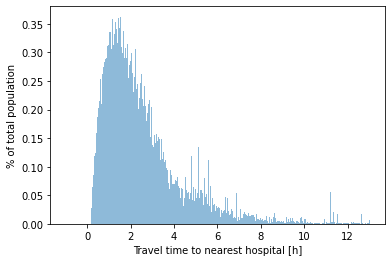

In [38]:
# Plot results
%matplotlib inline
plt.figure()
origins['t_'+usual_origin].plot.hist(alpha=0.5,bins=500,cumulative=False,density=True)
plt.ylabel('% of total population')
plt.xlabel('Travel time to nearest health center [h]')
plt.savefig(RESULTSFILEPATH+'/travel_time_dist.pdf')
plt.show()

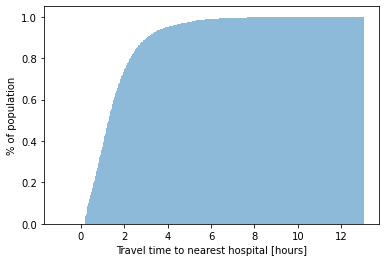

In [39]:
plt.figure()
origins['t_'+usual_origin].plot.hist(alpha=0.5,bins=500,cumulative=True,density=True,weights=origins['tot_pop'])
plt.ylabel('% of population')
plt.xlabel('Travel time to nearest '+usual_origin+' [hours]')
plt.savefig(RESULTSFILEPATH+'/travel_time_percentage')
plt.show()